## <font color='indianred'> Exercise 1: Explore filter parameters </font>

In this exercises you will explore how different parameters affect the filtering process.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))

from utils import download_data
import lfp_functions as lf

**Q 1.1 - Import the data from `data/moving_lfp.pickle` (I should already have this)**

In [2]:
with open('data/moving_lfp.pickle','rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']

print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


**Q 1.2 - Take a few seconds of the data and filter them in different frequency bands, plotting the resulting signal. Fix the central frequency and play with the width of the band. Then, try to change the central frequency of the band.**

As was done in the lecture, I'll use the Butterworth filter, keeping the order fixed at 5.

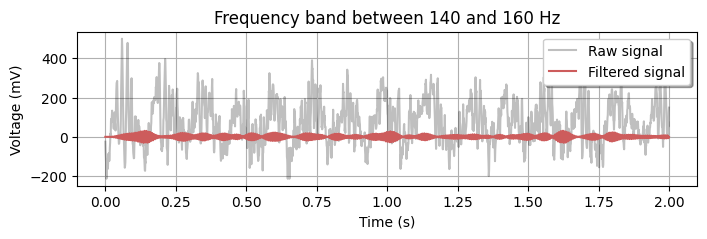

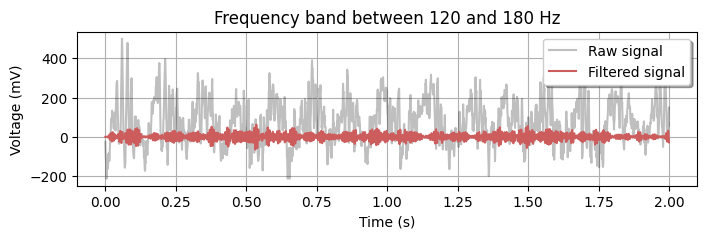

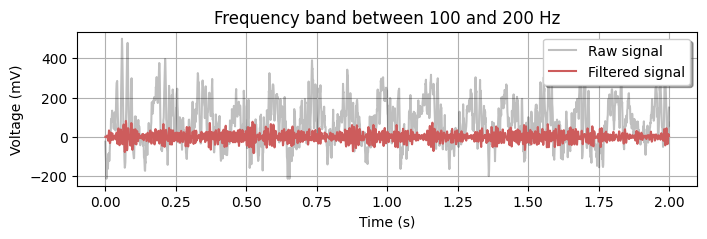

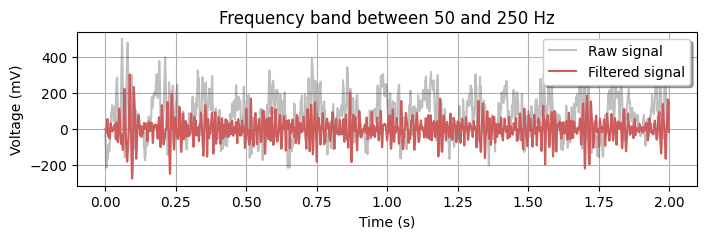

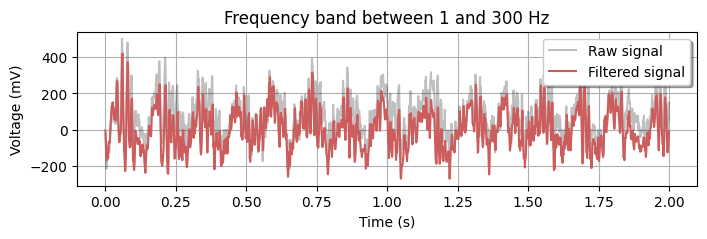

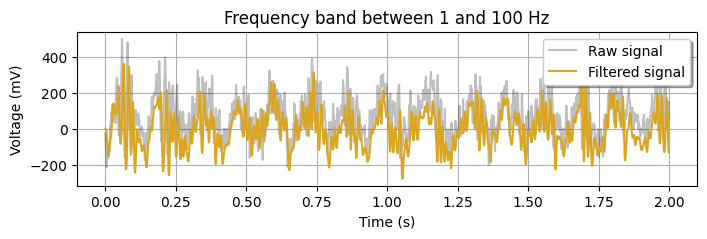

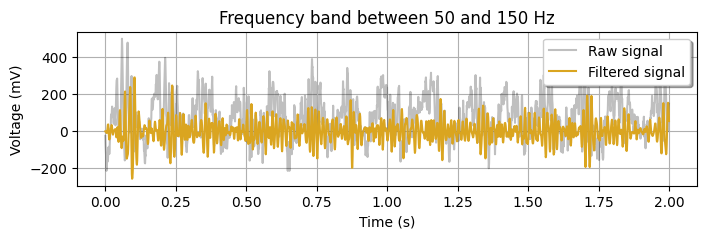

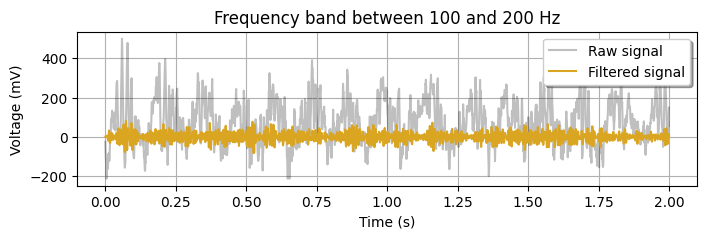

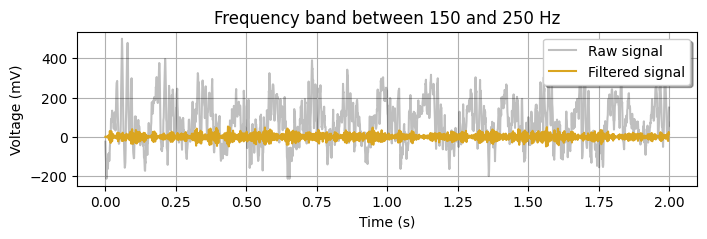

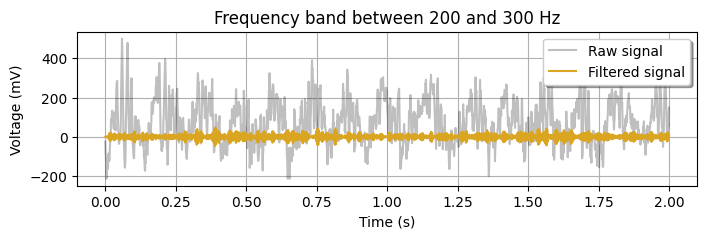

In [3]:
from scipy.signal import butter, sosfilt

filter_order = 5
start, finish, steps = 0, 2, 2000
times = np.linspace(start, finish, steps)

# Fix central frequency and change width
frequency_bands1 = [[140,160], [120,180],[100,200],[50,250],[1,300]]
for indx in range(len(frequency_bands1)):
    filter = butter(filter_order, frequency_bands1[indx], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)

    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='indianred')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Frequency band between {} and {} Hz'.format(frequency_bands1[indx][0], frequency_bands1[indx][1]))
    plt.show()

# Fix bandwidth and change center of frequency band
frequency_bands2 = [[1,100],[50,150],[100,200],[150,250],[200,300]]
for indx in range(len(frequency_bands2)):
    filter = butter(filter_order, frequency_bands2[indx], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)

    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='goldenrod')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Frequency band between {} and {} Hz'.format(frequency_bands2[indx][0], frequency_bands2[indx][1]))
    plt.show()

**Q 1.3 - Change the order of the filter whilst keeping the frequency band fixed. How does the signal change? How does the computing time change?**

It seems that chagning the order (omcreasing or decreasing) results in a somewhat phase shift? Why? 

As for the computing time, the greater the prder of the filter the longer it takes.

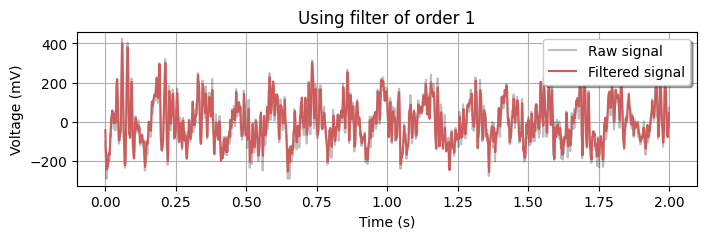

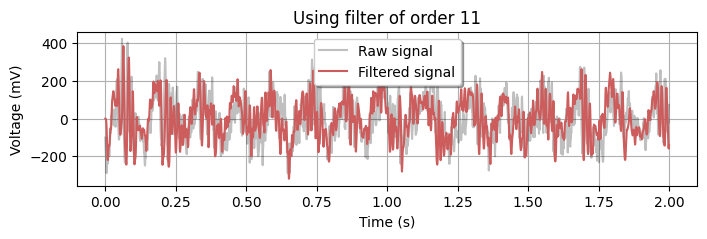

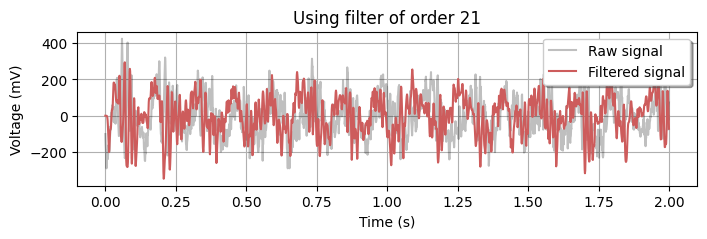

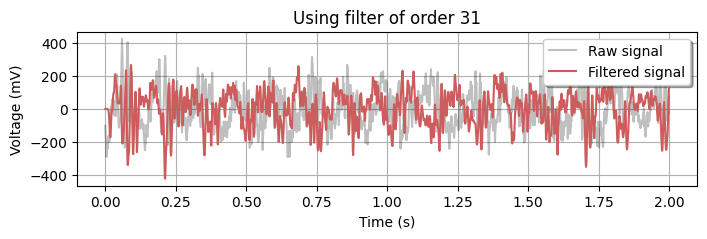

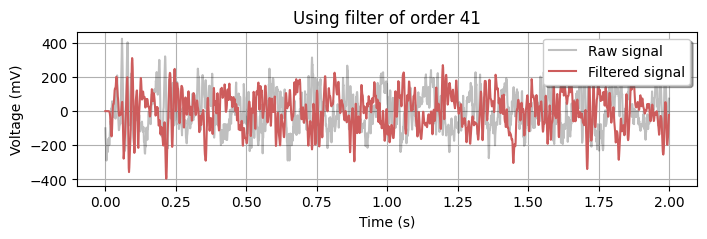

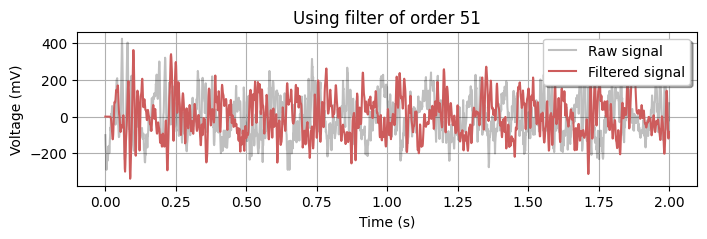

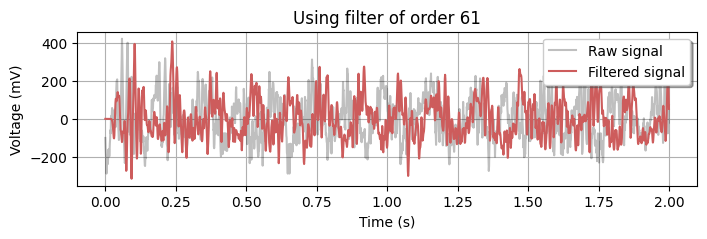

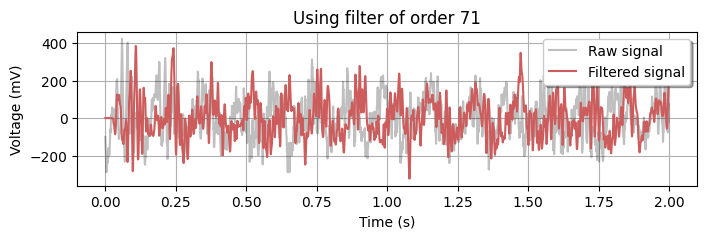

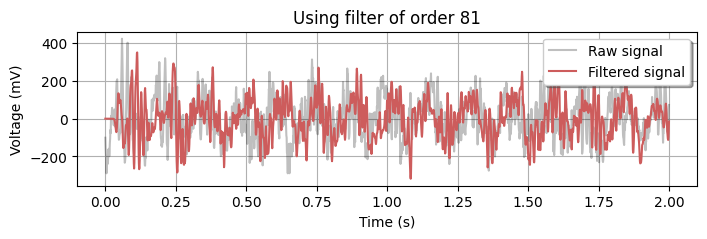

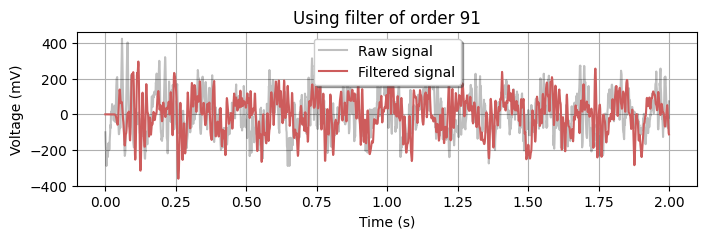

In [16]:
import time
# no need for such high order
filter_orders = np.arange(1,100,10)
start, finish, steps = 0, 2, 2000
times = np.linspace(start, finish, steps)
elapsed_times = []

for order in filter_orders:

    start = time.time()
    filter = butter(order, [1,200], btype = 'band', output = 'sos', fs = sampling_rate)
    wideband_lfp = sosfilt(filter, lfp)
    end = time.time()
    elapsed_times.append(end - start)

    # PLOTS  
    plt.figure(figsize=(8,2))
    plt.plot(times, lfp[:steps], label = 'Raw signal', color='k', alpha = 0.25)
    plt.plot(times, wideband_lfp[:steps], label = 'Filtered signal', color='indianred')
    plt.grid()
    plt.legend(shadow = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('Using filter of order {}'.format(order))
    plt.show()

Text(0, 0.5, 'Computation time')

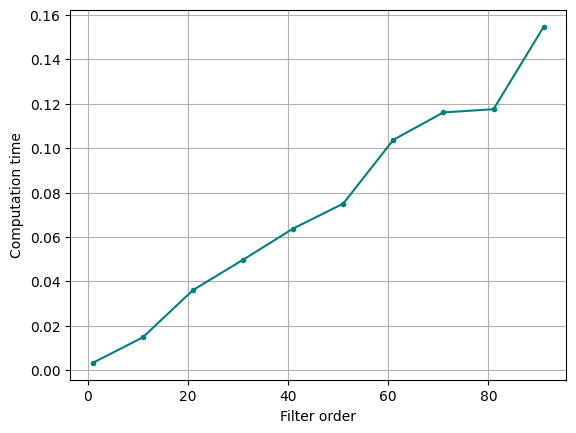

In [17]:
# PLOT ELAPSED TIMES WITH INCREASING FILTER_ORDER
plt.plot(filter_orders, elapsed_times, '.-', color='teal')
plt.grid()
plt.xlabel('Filter order')
plt.ylabel('Computation time')

## <font color='indianred'> Exercise 2: Wavelet transform with real wavelets </font>

In this exercise, you will explore the difference between real and complex wavelets in the CWT.

**Q 2.1 - Select a period of a few seconds of the signal and compute the spectrogram. Try the wavelet transform with `mexh`, `gaus` and `morl`. These are real wavelets.**

*Note to self: A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies in time!*

In [6]:
import pywt
print(pywt.wavelist('mexh'))
print(pywt.wavelist('gaus'))
print(pywt.wavelist('morl'))

['mexh']
['gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8']
['morl']


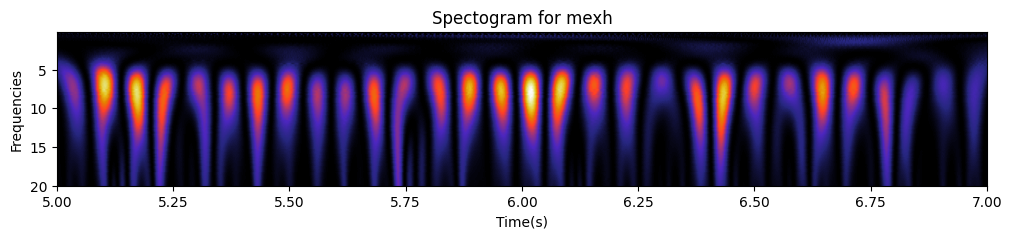

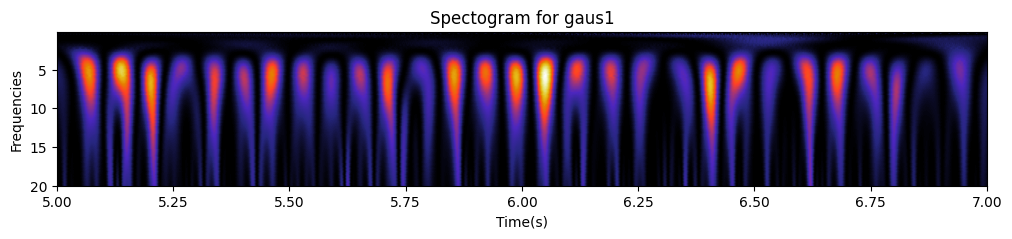

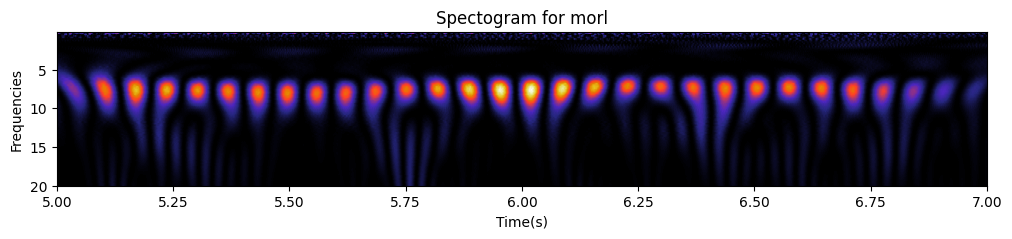

In [7]:
start, finish = 5,7

# int(s * Hz) = int(s * 1/s) = int(index)
signal = lfp[int(start * sampling_rate) : int(finish * sampling_rate)]

# Detrending
signal -= np.mean(signal) 

# Spectrograms 
wavelets = ['mexh', 'gaus1', 'morl']
frequencies = np.linspace(0.1, 20, 100) / sampling_rate

for wavelet in wavelets:
    scales = pywt.scale2frequency(wavelet, scale = frequencies)
    cwt_matrix, _ = pywt.cwt(signal, wavelet = wavelet, scales = scales)
    plt.figure(figsize=(12,2))
    
    plt.imshow(abs(cwt_matrix)**2, aspect='auto', cmap='CMRmap', extent=[start, finish, frequencies[-1] * sampling_rate,
                                    frequencies[0] * sampling_rate])
    plt.title('Spectogram for {}'.format(wavelet))
    plt.xlabel('Time(s)')
    plt.ylabel('Frequencies')
    plt.show()

**Q 2.2 - What differences do you see with respect to the spectrum computed with the complex Morlet transform? Comment on what do you think are the reasons for the differences (or not).**



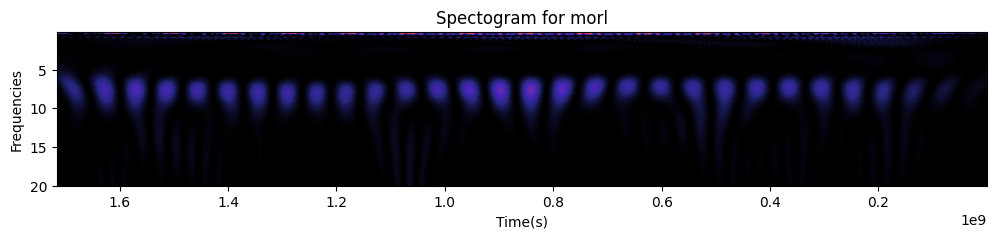

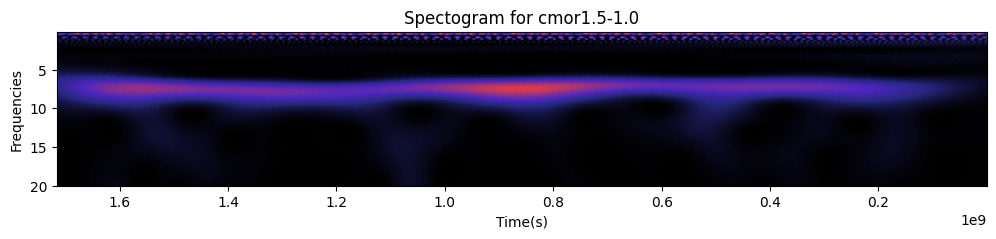

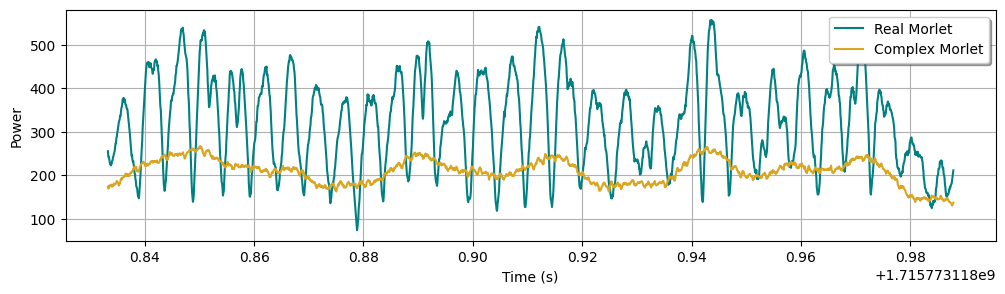

In [26]:
question2_wavelets = ['morl', 'cmor1.5-1.0']
cwt_mats = []
for wavelet in question2_wavelets:
    scales = pywt.scale2frequency(wavelet, scale = frequencies)
    cwt_matrix, _ = pywt.cwt(signal, wavelet = wavelet, scales = scales)
    cwt_mats.append(cwt_matrix)
    plt.figure(figsize=(12,2))
    
    plt.imshow(abs(cwt_matrix)**2, aspect='auto', cmap='CMRmap', extent=[start, finish, frequencies[-1] * sampling_rate,
                                    frequencies[0] * sampling_rate])
    plt.title('Spectogram for {}'.format(wavelet))
    plt.xlabel('Time(s)')
    plt.ylabel('Frequencies')
    plt.show()


power_real_morlet = np.mean(abs(cwt_mats[0]), axis = 0)
power_complex_morlet = np.mean(abs(cwt_mats[1]), axis = 0)

plt.figure(figsize=(12,3))
plt.plot(np.linspace(start,end, len(power_real_morlet)), power_real_morlet, color='teal', label ='Real Morlet')
plt.plot(np.linspace(start,end, len(power_complex_morlet)), power_complex_morlet, color='goldenrod', label ='Complex Morlet')
plt.grid()
plt.legend(shadow=True)
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.show()

## <font color='indianred'> Exercise 3: REM sleep detection </font>

**THE DATA FILE IS NOT THE CORRECT ONE!! THIS MAY EXPLAIN THE ON-AND-OFF VERY SHORT PERIOD REM SLEEPS THAT I AM GETTING!!**

Mammmalian sleep is organized in different phases. Rapid eye movement (REM) sleep is a well studied phase with clear markers that make it detectable from LFP data. One of the most used markers is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep the former dominates in a pattern that resembles active behaviour.

In this exercise, we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

**Q 3.1 - Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands for the whole signal**

In [9]:
def instantaneous_power(signal, sp, band):
    '''
    Computes the instantaneous power. To preserve the time evolution/information, 
    a continuous wavelet transform is used.'''

    # Detrending
    signal -= np.mean(signal)

    # Apply Continuous Wavelet Transform
    freqs = np.linspace(band[0], band[1], 50) / sp
    scales = pywt.scale2frequency('morl', freqs)
    cwt, _ = pywt.cwt(signal, scales, 'morl')

    # Compute the power 
    power = np.mean(abs(cwt)**2, axis = 0)

    return power

theta_band, delta_band = [6,10], [2,4]
theta_power = instantaneous_power(lfp, sampling_rate, theta_band)
delta_power = instantaneous_power(lfp, sampling_rate, delta_band)

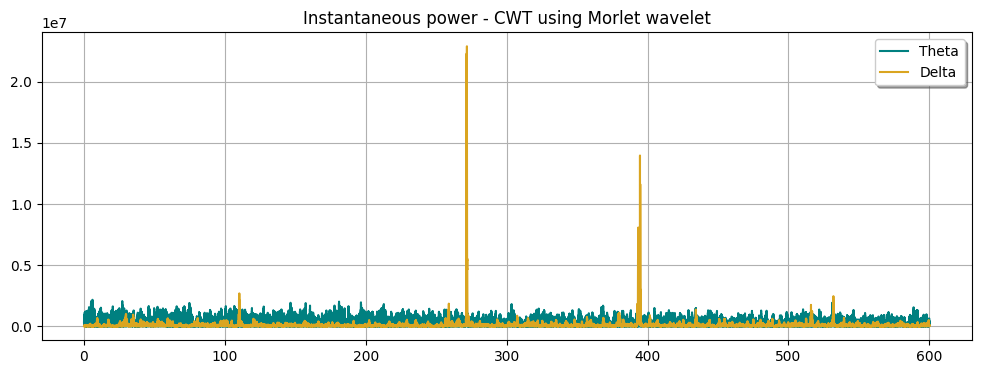

In [10]:
time = np.linspace(0, len(lfp)/sampling_rate, len(lfp))

plt.figure(figsize=(12,4))
plt.title('Instantaneous power - CWT using Morlet wavelet')
plt.grid()
plt.plot(time, theta_power, color='teal', label='Theta')
plt.plot(time, delta_power, color='goldenrod', label='Delta')
plt.legend(shadow=True)

**Q 3.2 - Z-score the two power signals**

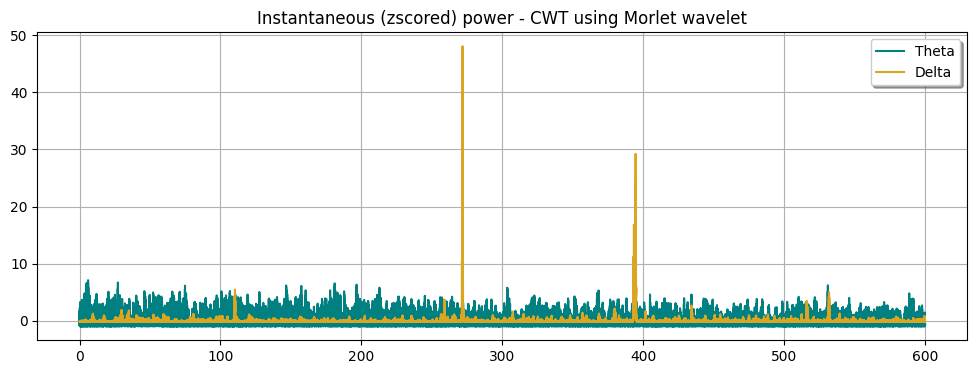

In [11]:
from scipy.stats import zscore
theta_power = zscore(theta_power)
delta_power = zscore(delta_power)

plt.figure(figsize=(12,4))
plt.title('Instantaneous (zscored) power - CWT using Morlet wavelet')
plt.grid()
plt.plot(time, theta_power, color='teal', label='Theta')
plt.plot(time, delta_power, color='goldenrod', label='Delta')
plt.legend(shadow=True)

**Q 3.3 - Compute and plot the power difference for the sleep session**

(0.0, 100.0)

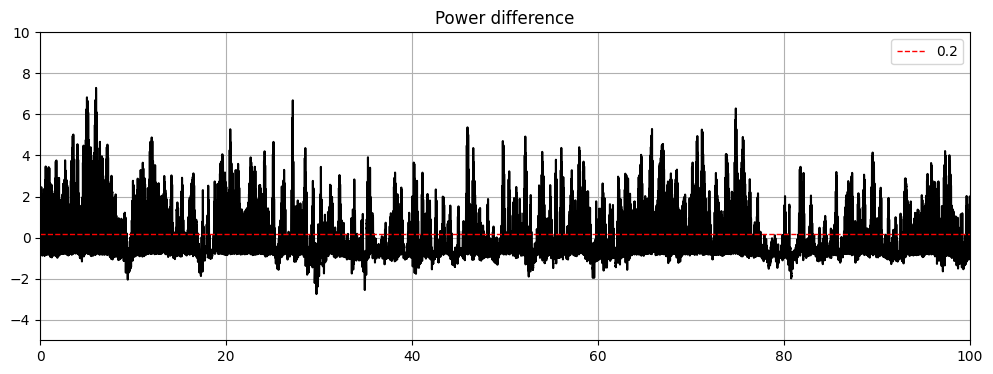

In [12]:
power_difference = theta_power - delta_power

plt.figure(figsize=(12,4))
plt.title('Power difference')
plt.grid()
plt.plot(time, power_difference, color='k')
plt.axhline(y = 0.2, color='red', linewidth=1, linestyle='--', label ='0.2')
plt.legend()
plt.ylim([-5, 10])
plt.xlim([0, 100])

**Q 3.4 - Compute the REM (`power_difference > 0.2`) and nREM (`power_difference < 0.2`) for the sleep session.**

In [13]:
power_dif_threshold = 0.2
rem_mask = np.asarray([True if x > power_dif_threshold else False for x in power_difference])
nrem_mask = np.asarray([True if x < power_dif_threshold else False for x in power_difference])

def finding_sleep_regimes(sleep_mask): # Cucumber disks over the eyes ahahah
    sleep_starts, sleep_ends = [], []

    for i in range(1, len(sleep_mask)):
        if sleep_mask[i-1] == 0 and sleep_mask[i] == 1:
            sleep_starts.append(i)
        if sleep_mask[i-1] == 1 and sleep_mask[i] == 0:
            sleep_ends.append(i)
    
    if len(sleep_ends) > len(sleep_starts):
        sleep_starts = [0] + sleep_starts  # if session starts with sleeping regime

    if len(sleep_ends) < len(sleep_starts):
        sleep_ends.append(len(sleep_mask))  # if session ends with sleeping regime

    sleeps = [np.arange(sleep_starts[i], sleep_ends[i])
               for i in range(len(sleep_starts))]
    
    return sleeps

rem_sleeps = finding_sleep_regimes(rem_mask)
nrem_sleeps = finding_sleep_regimes(nrem_mask)
print('Found {} periods of REM sleep and {} periods of nREM sleep'.format(len(rem_sleeps), len(nrem_sleeps)))

Found 6375 periods of REM sleep and 6375 periods of nREM sleep


**Q 3.5 - Plot examples of REM and nREM LFP signals (wideband filtered between 1 and 200 Hz)**

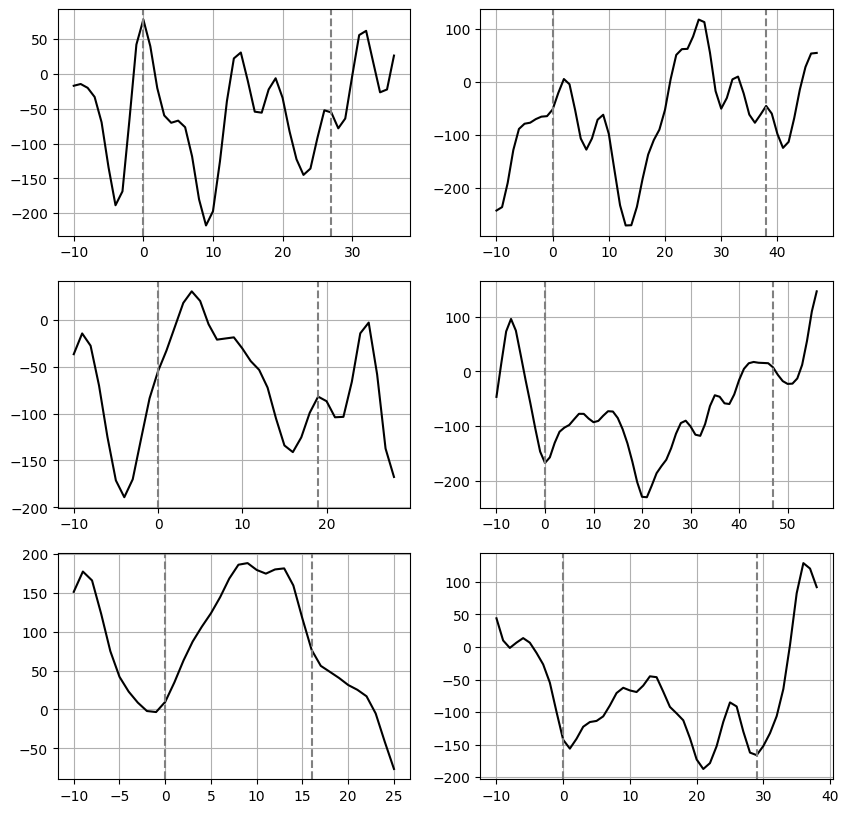

In [14]:
# Bandpass filter the sleep signal
sleep_lfp = lf.bandpass_filter(lfp, 1,200, sampling_rate) 

# REM SLEEP
selected_sleep_periods = np.arange(1,7) * 1000
rem_lengths  = [len(rem_sleeps[i]) for i in selected_sleep_periods]

plt.figure(figsize=(10,10))
for i,period in enumerate(selected_sleep_periods):
    
    rem_sleep_onset = rem_sleeps[period][0]
    x = np.arange(-10, rem_lengths[i]+10)
    #y_theta, y_delta = theta_power[rem_sleep_onsett-10: rem_sleep_onset+100], delta_power[rem_sleep_onset-10: rem_sleep_onset+100]
    y = sleep_lfp[rem_sleep_onset - 10: rem_sleep_onset + rem_lengths[i] + 10]
    
    plt.subplot(3, 2, i+1)
    #plt.plot(x, y_theta, color='teal', label='Theta')
    #plt.plot(x, y_delta, color='goldenrod', label='Delta')
    plt.plot(x, y, color='k')
    plt.axvline(x = 0, color='grey',linestyle='--', label='Onset of REM sleep')
    plt.axvline( x = rem_lengths[i], color='grey',linestyle='--', label='End of REM sleep')
    #plt.legend(shadow=True, loc=[0.70, 0.75])
    plt.grid()

**Q 3.6 - Explore how changing the threshold affects the amount of REM sleep detected**

Text(0, 0.5, '# REM sleep intervals')

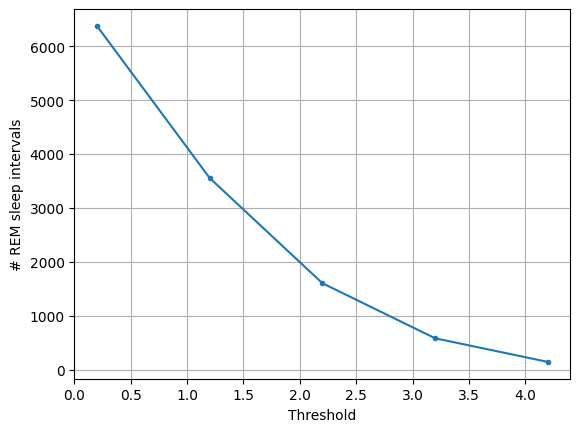

In [15]:
# Thresholds
power_dif_thresholds = np.arange(0.2, 5)
rems, n_rems = [], []

for power_dif_threshold in power_dif_thresholds:
    
    # Building each sleep regime's mask
    rem_mask = np.asarray([True if x > power_dif_threshold else False for x in power_difference])
    nrem_mask = np.asarray([True if x < power_dif_threshold else False for x in power_difference])

    rem_sleeps = finding_sleep_regimes(rem_mask)
    nrem_sleeps = finding_sleep_regimes(nrem_mask)

    rems.append(len(rem_sleeps))
    n_rems.append(len(nrem_sleeps))

plt.plot(power_dif_thresholds, rems, '.-')
plt.grid()
plt.xlabel('Threshold')
plt.ylabel('# REM sleep intervals')
